# Model Training

In [225]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Complex Dataset - 223 Features

In [226]:
# Load dataset
df = pd.read_csv('./data/AAPL_preprocessed_data.csv')

# Drop 'time_stamp' column and reverse order
timeseries = df.drop(columns=['time_stamp']).iloc[::-1]

# Train-test split
train_size = int(len(timeseries) * 0.9)
train, test = timeseries[:train_size], timeseries[train_size:]

In [227]:
#Choose scalar function
def choose_scaler(columns, mm_features, ss_features):
    for col in columns:
        mean = train[col].mean()
        std = train[col].std()
        min_val, max_val = train[col].min(), train[col].max()

        price_columns = ['open', 'high', 'low', 'close']
        if col in price_columns:
            ss_features.append(col)
        elif min_val >= 0 and max_val <= 100: # Likely a bounded indicator, use minmax
            mm_features.append(col)
        elif abs(mean) < std: # Likely unbounded, use StandardScaler
            ss_features.append(col)
        else:
            mm_features.append(col)

        return mm_features, ss_features
    

In [228]:
mm_features, ss_features = choose_scaler(train.columns, [], [])

# Initialize scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Scale features for training and testing
train_scaled = train.copy()
test_scaled = test.copy()

# Apply MinMaxScaler to selected features
for col in mm_features:
    train_scaled[col] = min_max_scaler.fit_transform(train[[col]])
    test_scaled[col] = min_max_scaler.transform(test[[col]])

# Apply StandardScaler to selected features
for col in ss_features:
    train_scaled[col] = standard_scaler.fit_transform(train[[col]])
    test_scaled[col] = standard_scaler.transform(test[[col]])


train = train_scaled.values.astype('float32')
test = test_scaled.values.astype('float32')

# Create dataset
def create_dataset(dataset, lookback, close_col):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i: i + lookback]
        target = dataset[i + lookback, close_col]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))


lookback = 10
close_col = df.columns.get_loc('close')
X_train, y_train = create_dataset(train, lookback, close_col)
X_test, y_test = create_dataset(test, lookback, close_col)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([5672, 10, 223]) torch.Size([5672])
torch.Size([622, 10, 223]) torch.Size([622])


In [229]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_layers, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(num_features, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the last time step
        return out

Epoch: 1/10, Train Loss: 47432400.1548, Test Loss: 9233505.1529
Epoch: 2/10, Train Loss: 47432393.0807, Test Loss: 9233500.6104
Epoch: 3/10, Train Loss: 47432386.0065, Test Loss: 9233495.1594
Epoch: 4/10, Train Loss: 47432380.3472, Test Loss: 9233490.6169
Epoch: 5/10, Train Loss: 47432371.8582, Test Loss: 9233484.7117
Epoch: 6/10, Train Loss: 47432366.1988, Test Loss: 9233479.7149
Epoch: 7/10, Train Loss: 47432359.1247, Test Loss: 9233474.7182
Epoch: 8/10, Train Loss: 47432353.4653, Test Loss: 9233469.2672
Epoch: 9/10, Train Loss: 47432347.8060, Test Loss: 9233464.7247
Epoch: 10/10, Train Loss: 47432339.3170, Test Loss: 9233459.2737


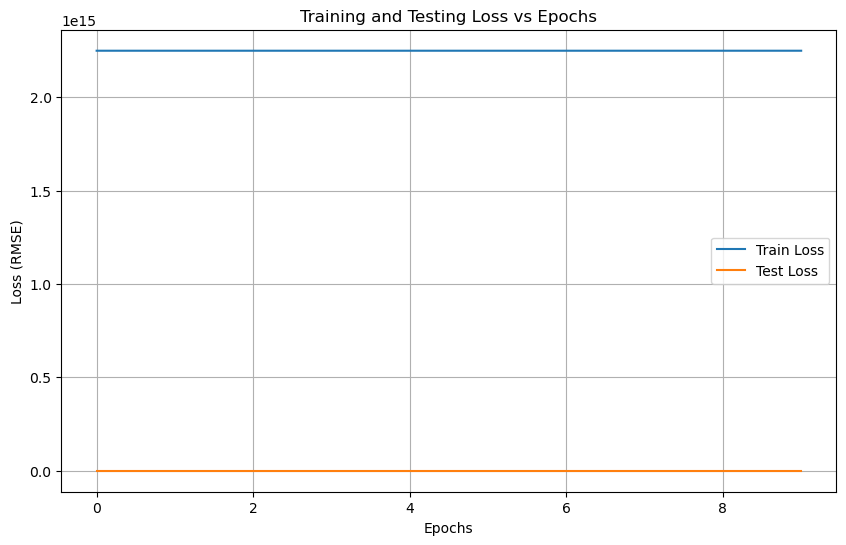

<Figure size 640x480 with 0 Axes>

In [230]:
# Initialize the model
num_features = X_train.shape[2]
hidden_dim = 50
num_layers = 1
output_size = 1

model = LSTMModel(num_features, hidden_dim, num_layers, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# DataLoader
loader = DataLoader(TensorDataset(X_train, y_train),
                    shuffle=True, batch_size=8)

# Train the model
epochs = 10
train_losses = []  # To store training loss
test_losses = []   # To store testing loss

for epoch in range(epochs):
    model.train()
    train_loss_epoch = 0
    for X_batch, y_batch in loader:
        y_batch = y_batch.view(-1, 1)  # Reshape target to [batch_size, 1]
        y_pred = model(X_batch)  # Model output is [batch_size, 1]
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()  # Accumulate batch loss

    # Compute average training loss for this epoch
    train_loss_epoch /= len(loader)
    train_losses.append(train_loss_epoch)

    # Evaluate on training and test sets
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_train_actual = y_train.view(-1, 1)  # Reshape target to [batch_size, 1]
        train_rmse = np.sqrt(loss_fn(y_train_pred, y_train_actual).item())

        y_test_pred = model(X_test)
        y_test_actual = y_test.view(-1, 1)  # Reshape target to [batch_size, 1]
        test_rmse = np.sqrt(loss_fn(y_test_pred, y_test_actual).item())

        test_losses.append(test_rmse)  # Store test loss

    print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_rmse:.4f}, Test Loss: {test_rmse:.4f}")

# Save the model
torch.save(model.state_dict(), "complex_lstm_model.pth")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (RMSE)")
plt.title("Training and Testing Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()
plt.savefig("complex_lstm_loss.png")

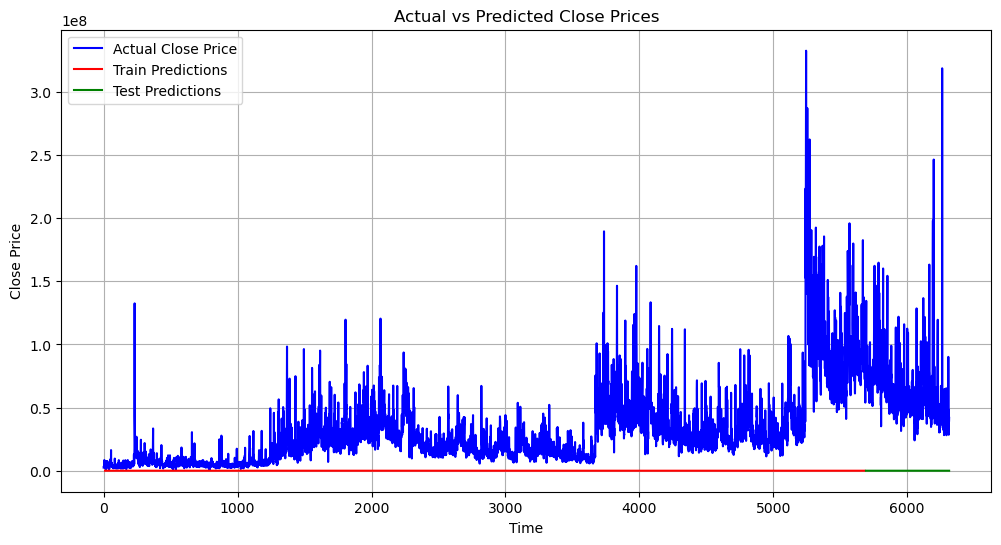

In [231]:
# Make predictions
with torch.no_grad():
    train_predictions = model(X_train)
    test_predictions = model(X_test)

    # Prepare plots
    train_plot = np.full_like(timeseries.iloc[:, 0].values, np.nan)  # Use .iloc for column indexing
    test_plot = np.full_like(timeseries.iloc[:, 0].values, np.nan)

    # Fill predictions in respective ranges
    train_plot[lookback:train_size] = train_predictions.squeeze()
    test_plot[train_size + lookback:] = test_predictions.squeeze()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(timeseries.iloc[:, close_col], label="Actual Close Price", color="blue")  # .iloc to access the column
plt.plot(train_plot, label="Train Predictions", color="red")
plt.plot(test_plot, label="Test Predictions", color="green")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.grid()
plt.savefig("lstm_predictions.png")
plt.show()


### Simple Dataset

In [252]:
simple_df = df.loc[:, ['open', 'high', 'low', 'close', 'SMA_10', 'RMA_10', 'EMA_10', 'DEMA_10', 'TEMA_10', 'WMA_10']]

simple_df.head()

,open,high,low,close,SMA_10,RMA_10,EMA_10,DEMA_10,TEMA_10,WMA_10
0,0.714286,0.720446,0.690804,0.693036,0.778214,0.790228,0.778214,0.778214,0.778214,0.800679
1,0.696429,0.729375,0.690268,0.716518,0.778214,0.790228,0.778214,0.778214,0.778214,0.800679
2,0.728750,0.743304,0.723214,0.727679,0.778214,0.790228,0.778214,0.778214,0.778214,0.800679
3,0.732679,0.762232,0.719821,0.746607,0.778214,0.790228,0.778214,0.778214,0.778214,0.800679
4,0.755536,0.789018,0.750000,0.788482,0.778214,0.790228,0.778214,0.778214,0.778214,0.800679


In [233]:
simple_df.describe()

,open,high,low,close,SMA_10,RMA_10,EMA_10,DEMA_10,TEMA_10,WMA_10
count,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000,6314.000000
mean,41.799612,42.244268,41.376093,41.830548,41.661165,41.499038,41.662545,41.827208,41.829033,41.717072
std,59.351027,59.974434,58.776681,59.410460,59.157159,58.920516,59.152347,59.398608,59.401393,59.232899
min,0.231964,0.235536,0.227143,0.234286,0.238482,0.245587,0.241374,0.235163,0.232590,0.238831
25%,2.286429,2.315268,2.245357,2.271607,2.271669,2.267825,2.272831,2.272326,2.272923,2.280166
50%,15.816429,16.014820,15.640714,15.811429,15.776055,15.732318,15.773545,15.807140,15.794838,15.794247
75%,45.072500,45.597500,44.557500,44.994375,44.834438,45.423857,45.289185,44.894343,44.941333,44.723943
max,242.870000,244.110000,241.250000,243.010000,235.283000,233.390441,236.505890,241.192528,243.319293,237.890727


In [234]:


# Train-test split
train_size = int(len(simple_df) * 0.9)
train, test = simple_df[:train_size], simple_df[train_size:]


In [235]:
lookback = 10
close_col = simple_df.columns.get_loc('close')

test = test.values.astype("float32")
train = train.values.astype("float32")
X_train, y_train = create_dataset(train, lookback, close_col)
X_test, y_test = create_dataset(test, lookback, close_col)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



torch.Size([5672, 10, 10]) torch.Size([5672])
torch.Size([622, 10, 10]) torch.Size([622])


Epoch: 1/1000, Train Loss: 33.6664, Test Loss: 151.5926
Epoch: 2/1000, Train Loss: 28.9473, Test Loss: 137.9339
Epoch: 3/1000, Train Loss: 26.9061, Test Loss: 131.7458
Epoch: 4/1000, Train Loss: 21.5506, Test Loss: 114.0943
Epoch: 5/1000, Train Loss: 18.1266, Test Loss: 102.3656
Epoch: 6/1000, Train Loss: 15.0682, Test Loss: 91.3433
Epoch: 7/1000, Train Loss: 11.6590, Test Loss: 78.9571
Epoch: 8/1000, Train Loss: 8.8955, Test Loss: 67.8825
Epoch: 9/1000, Train Loss: 10.0704, Test Loss: 72.7847
Epoch: 10/1000, Train Loss: 7.5835, Test Loss: 62.3454
Epoch: 11/1000, Train Loss: 6.9308, Test Loss: 58.6753
Epoch: 12/1000, Train Loss: 6.6630, Test Loss: 56.7350
Epoch: 13/1000, Train Loss: 7.1651, Test Loss: 60.4895
Epoch: 14/1000, Train Loss: 13.3389, Test Loss: 85.1603
Epoch: 15/1000, Train Loss: 9.3627, Test Loss: 69.9210
Epoch: 16/1000, Train Loss: 9.4313, Test Loss: 70.2276
Epoch: 17/1000, Train Loss: 7.5321, Test Loss: 61.3703
Epoch: 18/1000, Train Loss: 10.6528, Test Loss: 73.2774
Epoc

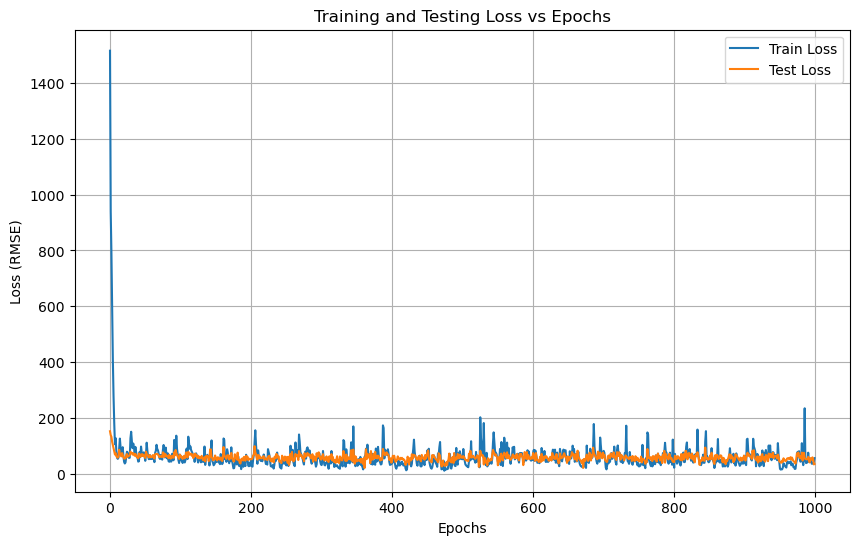

<Figure size 640x480 with 0 Axes>

In [236]:
# Initialize the model
num_features = X_train.shape[2]
hidden_dim = 50
num_layers = 1
output_size = 1

model = LSTMModel(num_features, hidden_dim, num_layers, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# DataLoader
loader = DataLoader(TensorDataset(X_train, y_train),
                    shuffle=True, batch_size=8)

# Train the model
epochs = 1000
train_losses = []  # To store training loss
test_losses = []   # To store testing loss

for epoch in range(epochs):
    model.train()
    train_loss_epoch = 0
    for X_batch, y_batch in loader:
        y_batch = y_batch.view(-1, 1)  # Reshape target to [batch_size, 1]
        y_pred = model(X_batch)  # Model output is [batch_size, 1]
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()  # Accumulate batch loss

    # Compute average training loss for this epoch
    train_loss_epoch /= len(loader)
    train_losses.append(train_loss_epoch)

    # Evaluate on training and test sets
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_train_actual = y_train.view(-1, 1)  # Reshape target to [batch_size, 1]
        train_rmse = np.sqrt(loss_fn(y_train_pred, y_train_actual).item())

        y_test_pred = model(X_test)
        y_test_actual = y_test.view(-1, 1)  # Reshape target to [batch_size, 1]
        test_rmse = np.sqrt(loss_fn(y_test_pred, y_test_actual).item())

        test_losses.append(test_rmse)  # Store test loss

    print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_rmse:.4f}, Test Loss: {test_rmse:.4f}")

# Save the model
torch.save(model.state_dict(), "simple_lstm_model.pth")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (RMSE)")
plt.title("Training and Testing Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()
plt.savefig("simple_lstm_loss.png")


Train predictions shape: torch.Size([5672, 1])
Test predictions shape: torch.Size([622, 1])


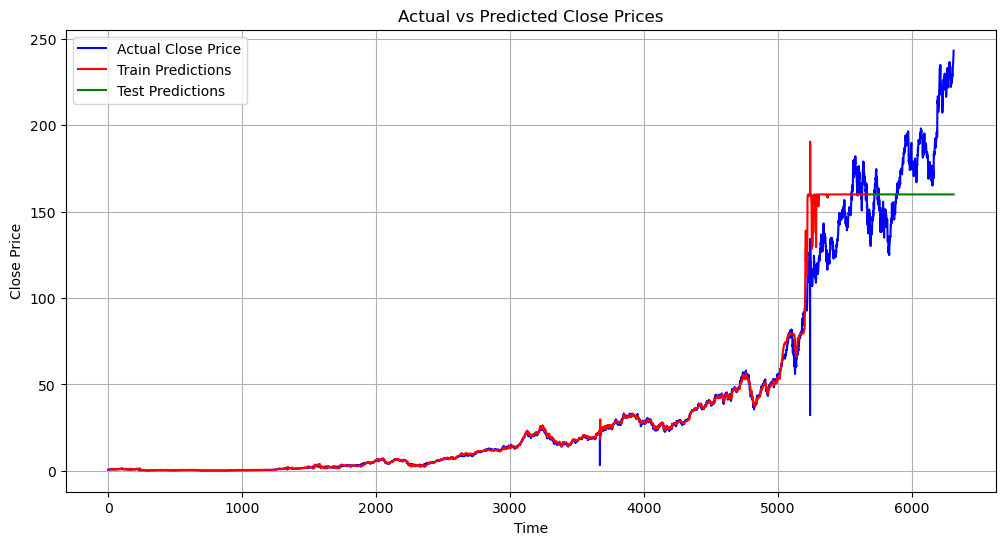

In [237]:
# Make predictions
with torch.no_grad():
    train_predictions = model(X_train)
    test_predictions = model(X_test)

    print(f"Train predictions shape: {train_predictions.shape}")
    print(f"Test predictions shape: {test_predictions.shape}")


    # Prepare plots
    train_plot = np.full_like(simple_df.iloc[:, 0].values, np.nan)  # Use .iloc for column indexing
    test_plot = np.full_like(simple_df.iloc[:, 0].values, np.nan)

    # Fill predictions in respective ranges
    train_plot[lookback:train_size] = train_predictions.squeeze()
    test_plot[train_size + lookback:] = test_predictions.squeeze()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(simple_df.iloc[:, close_col], label="Actual Close Price", color="blue")  # .iloc to access the column
plt.plot(train_plot, label="Train Predictions", color="red")
plt.plot(test_plot, label="Test Predictions", color="green")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.grid()
plt.savefig("lstm_predictions.png")
plt.show()


In [238]:
print("Train Predictions Sample: ", train_predictions[:5])
print("Test Predictions Sample: ", test_predictions[:5])


Train Predictions Sample:  tensor([[0.7344],
        [0.7456],
        [0.7972],
        [0.7807],
        [0.8135]])
Test Predictions Sample:  tensor([[159.9130],
        [159.9130],
        [159.9129],
        [159.9129],
        [159.9129]])


### Lets try training the same model but starting on sample 3000 to see if we can get better future predictions

In [253]:
# Train-test split
simple_df = simple_df.iloc[3000:].reset_index(drop=True)
train_size = int(len(simple_df) * 0.75)
train, test = simple_df[:train_size], simple_df[train_size:]


lookback = 10
close_col = simple_df.columns.get_loc('close')

test = test.values.astype("float32")
train = train.values.astype("float32")
X_train, y_train = create_dataset(train, lookback, close_col)
X_test, y_test = create_dataset(test, lookback, close_col)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



torch.Size([2475, 10, 10]) torch.Size([2475])
torch.Size([819, 10, 10]) torch.Size([819])


Epoch: 1/1000, Train Loss: 42.3396, Test Loss: 158.7988
Epoch: 2/1000, Train Loss: 35.9782, Test Loss: 147.7861
Epoch: 3/1000, Train Loss: 31.3476, Test Loss: 138.4034
Epoch: 4/1000, Train Loss: 27.7517, Test Loss: 130.1394
Epoch: 5/1000, Train Loss: 24.7284, Test Loss: 122.5672
Epoch: 6/1000, Train Loss: 22.0249, Test Loss: 115.4487
Epoch: 7/1000, Train Loss: 19.4623, Test Loss: 108.3540
Epoch: 8/1000, Train Loss: 17.1064, Test Loss: 101.6824
Epoch: 9/1000, Train Loss: 15.4172, Test Loss: 96.7339
Epoch: 10/1000, Train Loss: 13.4654, Test Loss: 90.8165
Epoch: 11/1000, Train Loss: 11.6169, Test Loss: 85.2803
Epoch: 12/1000, Train Loss: 9.9958, Test Loss: 80.0451
Epoch: 13/1000, Train Loss: 8.5111, Test Loss: 75.2852
Epoch: 14/1000, Train Loss: 8.9576, Test Loss: 76.8255
Epoch: 15/1000, Train Loss: 7.5647, Test Loss: 71.8727
Epoch: 16/1000, Train Loss: 6.2904, Test Loss: 67.6437
Epoch: 17/1000, Train Loss: 5.3815, Test Loss: 64.0595
Epoch: 18/1000, Train Loss: 5.6359, Test Loss: 65.2231


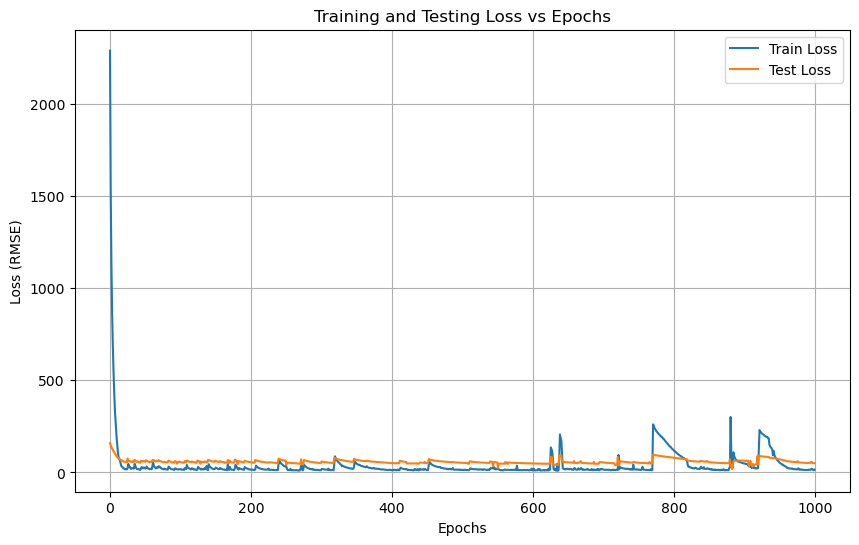

<Figure size 640x480 with 0 Axes>

In [254]:
# Initialize the model
num_features = X_train.shape[2]
hidden_dim = 50
num_layers = 1
output_size = 1

model = LSTMModel(num_features, hidden_dim, num_layers, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# DataLoader
loader = DataLoader(TensorDataset(X_train, y_train),
                    shuffle=True, batch_size=8)

# Train the model
epochs = 1000
train_losses = []  # To store training loss
test_losses = []   # To store testing loss

for epoch in range(epochs):
    model.train()
    train_loss_epoch = 0
    for X_batch, y_batch in loader:
        y_batch = y_batch.view(-1, 1)  # Reshape target to [batch_size, 1]
        y_pred = model(X_batch)  # Model output is [batch_size, 1]
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()  # Accumulate batch loss

    # Compute average training loss for this epoch
    train_loss_epoch /= len(loader)
    train_losses.append(train_loss_epoch)

    # Evaluate on training and test sets
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_train_actual = y_train.view(-1, 1)  # Reshape target to [batch_size, 1]
        train_rmse = np.sqrt(loss_fn(y_train_pred, y_train_actual).item())

        y_test_pred = model(X_test)
        y_test_actual = y_test.view(-1, 1)  # Reshape target to [batch_size, 1]
        test_rmse = np.sqrt(loss_fn(y_test_pred, y_test_actual).item())

        test_losses.append(test_rmse)  # Store test loss

    print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_rmse:.4f}, Test Loss: {test_rmse:.4f}")

# Save the model
torch.save(model.state_dict(), "simple_lstm_model.pth")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (RMSE)")
plt.title("Training and Testing Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()
plt.savefig("small_data_lstm_loss.png")


Train predictions shape: torch.Size([2475, 1])
Test predictions shape: torch.Size([819, 1])


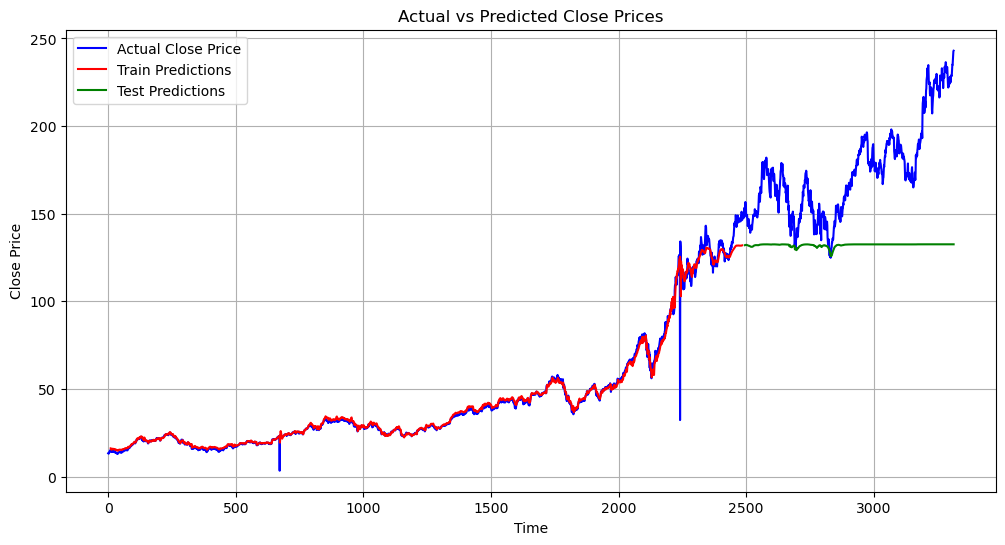

In [255]:
# Make predictions
with torch.no_grad():
    train_predictions = model(X_train)
    test_predictions = model(X_test)

    print(f"Train predictions shape: {train_predictions.shape}")
    print(f"Test predictions shape: {test_predictions.shape}")


    # Prepare plots
    train_plot = np.full_like(simple_df.iloc[:, 0].values, np.nan)  # Use .iloc for column indexing
    test_plot = np.full_like(simple_df.iloc[:, 0].values, np.nan)

    # Fill predictions in respective ranges
    train_plot[lookback:train_size] = train_predictions.squeeze()
    test_plot[train_size + lookback:] = test_predictions.squeeze()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(simple_df.iloc[:, close_col], label="Actual Close Price", color="blue")  # .iloc to access the column
plt.plot(train_plot, label="Train Predictions", color="red")
plt.plot(test_plot, label="Test Predictions", color="green")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.grid()
plt.savefig("small_data_lstm_predictions.png")
plt.show()


In [256]:
print("Train Predictions Sample: ", train_predictions[:5])
print("Test Predictions Sample: ", test_predictions[:5])

Train Predictions Sample:  tensor([[16.1210],
        [16.1082],
        [15.5217],
        [15.3274],
        [15.3500]])
Test Predictions Sample:  tensor([[132.0556],
        [132.0984],
        [132.1498],
        [132.1893],
        [132.2079]])
